## Predict Final Result Block
跑完這個 block 以後，就可以得到 final CSV

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
import csv

data = pd.read_csv('./fixed_test.csv')

# Create Dataframe
df = pd.DataFrame(data)
patientList = df['PATIENT ID'].to_numpy()
df = df.drop(columns=['admission_datetime', 'PATIENT ID', 'sex'])

# Since ed_diagnosis is STRING LABEL, we need to transform the string to integer label for further training
df = pd.get_dummies(df)

# Fill NAN values
headerList = df.columns.values.tolist()
filteredList = list(filter(lambda name: 'pmhx' in name, headerList)) # need to fill mode
otherList = list(filter(lambda name: 'pmhx' not in name, headerList)) # need to fill mean

for filteredCol in filteredList:
  df[filteredCol].fillna(df[filteredCol].mode()[0], inplace=True)

for otherCol in otherList:
  df[otherCol].fillna(df[otherCol].mean(), inplace=True)

final_data_list = df.to_numpy()

from tensorflow import keras
model = keras.models.load_model('1.19_draft.h5')
predict_ans = model.predict(final_data_list)
predict_ans = predict_ans.round()

with open('106062322.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['PATIENT ID', 'hospital_outcome'])
  for idx, val in enumerate(predict_ans):
    writer.writerow([ patientList[idx], int(predict_ans[idx][0])])

## HW2: Classification implementation
**It's unnecessary to run if only need to generate predict result!**


## Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import seaborn
# plot ROC curve
def plot_roc(label, pred):
  fpr, tpr, _ = roc_curve(label, pred)
  roc_auc = auc(fpr, tpr)

  fig = plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  return

def plot_precision_recall(label, pred):
  precision = metrics.precision_score(label, pred)
  recall = metrics.recall_score(label, pred)
  confusion_metrix = metrics.confusion_matrix(label, pred)
  seaborn.heatmap(confusion_metrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
  plt.show()
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"Precision + Recall: {precision + recall}")
  # print(precision, recall)
  # print(confusion_metrix)
  return

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
  return

In [ ]:

data = pd.read_csv('/content/drive/My Drive/ML-Homework/hw2/hm_hospitales_covid_structured_30d_train.csv')
ans_data = pd.read_csv('/content/drive/My Drive/ML-Homework/hw2/split_train_export_30d.csv')

# Create Dataframe
df = pd.DataFrame(data)
ans_df = pd.DataFrame(ans_data)

df = df.drop(columns=['admission_datetime', 'PATIENT ID', 'sex'])
ans_df = ans_df.drop(columns=['PATIENT ID'])

# Since ed_diagnosis is STRING LABEL, we need to transform the string to integer label for further training
# df['ed_diagnosis'] = labelencoder.fit_transform(df['ed_diagnosis'])
df = pd.get_dummies(df)

# Fill NAN values
headerList = df.columns.values.tolist()
filteredList = list(filter(lambda name: 'pmhx' in name, headerList)) # need to fill mode
otherList = list(filter(lambda name: 'pmhx' not in name, headerList)) # need to fill mean

for filteredCol in filteredList:
  df[filteredCol].fillna(df[filteredCol].mode()[0], inplace=True)

for otherCol in otherList:
  df[otherCol].fillna(df[otherCol].mean(), inplace=True)

# Normalize Data
# Reference to https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)


# Split data from original dataset
TRAIN_TEST_SPLIT_RATIO = 0.2

training_data_list, testing_data_list, training_ans_list, testing_ans_list = train_test_split(df, ans_df, test_size=TRAIN_TEST_SPLIT_RATIO, random_state=0)
# training_ans_list = training_ans_list.values.ravel()

# Increase dead person amout
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(ratio='minority')
training_data_list, training_ans_list = smote.fit_sample(training_data_list, training_ans_list)
print(f"Dead Count: {Counter(training_ans_list)}")

print(training_data_list)

Dead Count: Counter({0: 1263, 1: 1263})
[[ 59.          36.71511253 132.05660377 ...   0.           0.
    0.        ]
 [ 70.          36.71511253 132.05660377 ...   0.           0.
    0.        ]
 [ 61.          37.6        144.         ...   1.           0.
    0.        ]
 ...
 [ 76.18217361  36.19498306 117.27326042 ...   0.76765702   0.
    0.        ]
 [ 77.95454807  36.70861188 131.89246227 ...   0.           0.
    0.        ]
 [ 87.05637348  36.68163763 121.         ...   0.           0.
    0.70919844]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Random Forest Classifier

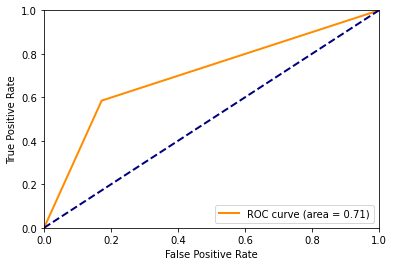

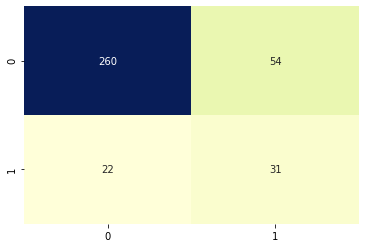

Precision: 0.36470588235294116
Recall: 0.5849056603773585
Precision + Recall: 0.9496115427302996


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, n_estimators=1050)
clf.fit(training_data_list, training_ans_list)
predict_result = clf.predict(testing_data_list)

plot_roc(testing_ans_list, predict_result)
plot_precision_recall(testing_ans_list, predict_result)

## Xgboost Classifier

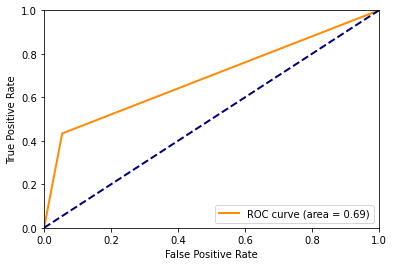

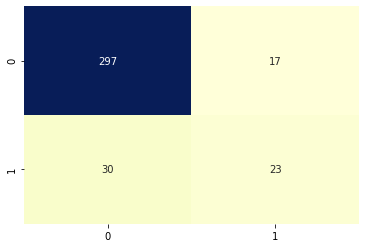

Precision: 0.575
Recall: 0.4339622641509434
Precision + Recall: 1.0089622641509433


In [ ]:
from xgboost import XGBClassifier
import numpy as np

xgbc = XGBClassifier(max_depth=3, n_estimators=490)
xgbc.fit(training_data_list, training_ans_list)
predict_result = xgbc.predict(testing_data_list.to_numpy())

plot_roc(testing_ans_list, predict_result)
plot_precision_recall(testing_ans_list, predict_result)

## Neural Network

Epoch 1/40
9/9 [==============================] - 0s 28ms/step - loss: 0.6994 - val_loss: 2.2204
Epoch 2/40
9/9 [==============================] - 0s 4ms/step - loss: 0.6438 - val_loss: 1.0920
Epoch 3/40
9/9 [==============================] - 0s 4ms/step - loss: 0.6076 - val_loss: 0.9296
Epoch 4/40
9/9 [==============================] - 0s 4ms/step - loss: 0.5691 - val_loss: 1.0067
Epoch 5/40
9/9 [==============================] - 0s 4ms/step - loss: 0.5530 - val_loss: 0.6865
Epoch 6/40
9/9 [==============================] - 0s 5ms/step - loss: 0.5216 - val_loss: 0.9137
Epoch 7/40
9/9 [==============================] - 0s 5ms/step - loss: 0.4988 - val_loss: 0.5566
Epoch 8/40
9/9 [==============================] - 0s 5ms/step - loss: 0.4741 - val_loss: 0.7374
Epoch 9/40
9/9 [==============================] - 0s 5ms/step - loss: 0.4675 - val_loss: 0.8028
Epoch 10/40
9/9 [==============================] - 0s 6ms/step - loss: 0.4758 - val_loss: 0.8256
Epoch 11/40
9/9 [=====================

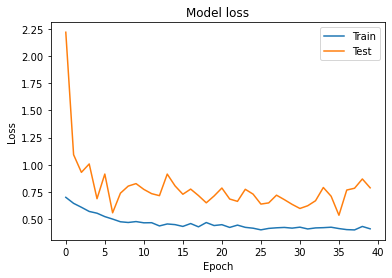

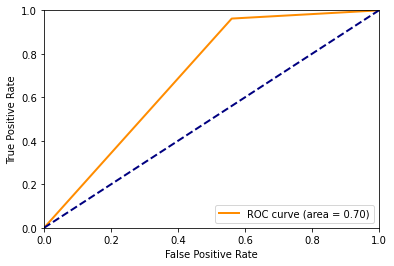

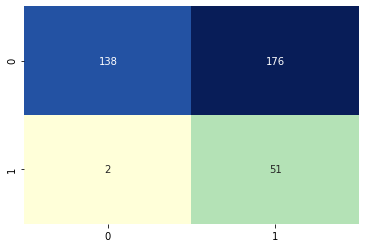

Precision: 0.22466960352422907
Recall: 0.9622641509433962
Precision + Recall: 1.1869337544676253


In [ ]:
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

# Normalization
# Dropout, adam -> sgd, layer increase
def net():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(40, activation='relu', input_shape=(49,)))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(40, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(40, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

model = net()
# model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
)
history = model.fit(training_data_list, training_ans_list, epochs=40, batch_size=312, validation_data=(testing_data_list, testing_ans_list))

# plot loss
plot_loss(history)

predict_result = model.predict(testing_data_list)
predict_result = predict_result.round() # Force output to [0, 1]
plot_roc(testing_ans_list, predict_result)
plot_precision_recall(testing_ans_list, predict_result)

In [ ]:
# model.save("./draft.h5")



[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.